### Solving for a private mean age of a population

In [1]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplace-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

def dp_mean(eps_n, eps_d, top, bot, top_sen=100.0, bot_sen=1.0):
  noisy_top = laplace_mech(top, eps_n, top_sen)
  noisy_bot = laplace_mech(bot, eps_d, bot_sen)
  return noisy_top / noisy_bot

def mse(true_answer, function_name, *params):
  """true_answer is either a scalar or numpy array"""
  niterations = 100_000
  return sum(np.sum((true_answer - function_name(*params))**2) for x in range(niterations)) / float(niterations)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def migrecode(migpuma):
    if pd.isnull(migpuma):
        return 0
    else:
        return 1

def avg_l1_mean(true_mean, eps, n=1000):
    total = 0
    for i in range(n):
        noisy_mean = dp_mean(eps/2, eps/2, total_age, total_population, age_sensitivity, population_sensitivity)
        accuracy = 1 - (np.linalg.norm([noisy_mean-true_mean], 1)/(2*1))
        total += accuracy
    return total/n

pa = pd.read_csv("psam_p22.csv")

pa['MIGRATED']=pa.MIGPUMA.apply(migrecode)

pa = pa.query('PUMA==2400 and MIGRATED==1')

total_age = pa.AGEP.sum()
total_population = float(pa.AGEP.size)
age_sensitivity = 99-0
population_sensitivity = 1.0

eps_n = 0.25
eps_d = 0.25
assert eps_n + eps_d <= 1.0000000001, "eps_n + eps_d must be at most 1"

def avg_l1_median(true_median, eps, n=1000):
    total = 0
    for i in range(n):
        noisy_median = laplace_mech(true_median, eps, age_sensitivity)
        accuracy = 1 - (np.linalg.norm([noisy_median-true_median], 1)/(2*1))
        total += accuracy
    return total/n



To solve for a private mean age of a population, we first:
1. get an estimate of the total age (by adding Laplace noise)
2. get an estimate of the total population (by adding Laplace noise)
3. divide the two estimates

We can do this with the `dp_mean()` function above, which also calls `laplace_mech()`.

We started above by loading the PUMS data.

Next, we queried the population we want to calculate the mean age of: people in PUMA 2400 who migrated from another PUMA.

Then we calculated the values we need for `dp_mean()`. These include the total age, the total population, the age sensitivity and the population sensitivity.

We calculate how much a single person can change the total age (numerator) or the total population (denominator). A single person can change the total population by 1, while a single person can change the total age by at most 99, since that is the topcode for age in this dataset.

We also need to consider our privacy budget, `eps`. We can take `eps` and split it into two pieces: one for estimating the numerator (`eps_n`) and another for estimating the denominator (`eps_d`), so that `eps = eps_n + eps_d`.

The choice of `eps_n` and `eps_d` clearly affects accuracy. A researcher can plug in different splits of `eps_n` and `eps_d` to see how low they can make the estimated mse. However, to be technically differentially private, this analysis of splits should not be done on the confidential data to which noise is being added. It would have to be done to dummy data.

In this case, differential privacy doesn't change the mean age much, even with a small epsilon, because adding or removing one person from the dataset results in a small relative change in the numerator and denominator. If our sample were smaller, then the same amount of noise to the numerator and denominator would result in more potential change in the mean.

We can test these values and their accuracy with the `dp_mean()` and `mse()` functions, like below. In this example, we use an epsilon of .5 for the mean, with .25 allocated to privacy loss in the numerator and .25 allocated to privacy loss in the denominator. 

In [2]:
raw_mean=pa.mean()
print("The raw mean is ",raw_mean['AGEP'].round(2))
#raw_sum=pa.sum()
#print(raw_sum)

noisy_mean = dp_mean(eps_n, eps_d, total_age, total_population, age_sensitivity, population_sensitivity)
error = mse(total_age/total_population, dp_mean, eps_n, eps_d, total_age, total_population, age_sensitivity, population_sensitivity)
print("A noisy mean is ", round(noisy_mean,2))
#print("mse is ", error)

The raw mean is  32.59
A noisy mean is  33.47


We want to be able to calculate the `noisy_mean` for different values of epsilon and calculate the average accuracy of the `noisy_mean` for each of these epsilons, so that we can compare the accuracy-privacy trade off. The function below does this using L1 norm as the accuracy measure.

Let's use `avg_l1_mean()` to calculate the average accuracy of the noisy mean over a range of epsilon values and visualize the output. Below is an ROC curve similar to what the DRB would need to approve noise.

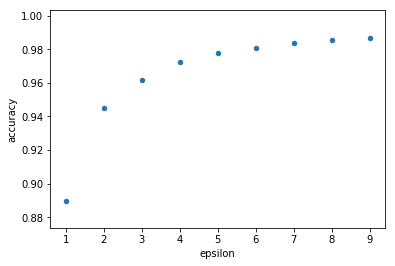

In [3]:
accuracy_df = pd.DataFrame()
eps_range = (np.arange(1.0,10.0,1))
accuracy_df['epsilon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_mean(total_age/total_population, x) for x in eps_range]
accuracy_df.plot.scatter('epsilon', 'accuracy')
plt.show()

### Solving for a private median age of a population

The median is more of a pain to calculate because the sensitivity is high. The sensitivity of the median is half of the difference between the maximum and minimum possible values of the variable.


In [6]:
true_median = pa.AGEP.median()

The sensitivity of a median is half of the possible range of the underlying variable. In this case, the age sensitivity is 99/2, since age is topcoded at 99 in this dataset. (Note: It does not matter whether there are 0-year-olds or 99-year-olds in the dataset. What's important is that such people are possible given the way the dataset is constructed.) Your dataset may topcode age at some different value or may not topcode age. Below we give a sample true median and noisy median, using an epsilon of 3.

In [7]:
age_sensitivity = (99-0)/2

In [8]:
print("True Median: ",true_median)

print("Noisy Median: ",round(laplace_mech(true_median,epsilon=3,sensitivity=99/2),2))

True Median:  30.0
Noisy Median:  38.28


We can now use `age_sensitivity` and `laplace_mech()` to calculate the `noisy_median`. We want to do this for different values of epsilon, and be able to calculate the average accuracy of the `noisy_median` for each of these epsilons, so that we can compare the accuracy-privacy trade off. The function below does this using L1 norm as the accuracy measure.

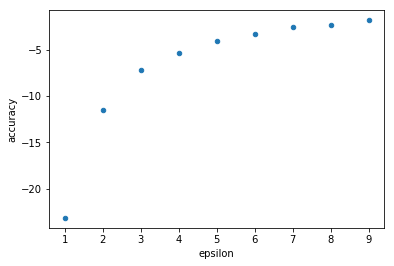

In [9]:
accuracy_df = pd.DataFrame()
eps_range = (np.arange(1.0,10.0,1))
accuracy_df['epsilon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_median(true_median, x) for x in eps_range]
accuracy_df.plot.scatter('epsilon', 'accuracy')
plt.show()

As you can see, a basic differential privacy approach will substantially degrade the data quality of medians. There is another way to do differentially private medians, but it is more complicated, and we do not yet have an implementation of it. This is an illustration of why the Census Bureau is not currently requiring differential privacy in every case.